In [1]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import tqdm

from src.segmentation.image import Preprocessor
from src.utils import Const

In [2]:
metadata = pd.read_csv(os.path.join(Const.DATASET_PATH, 'metadata.csv'))
metadata.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


Paths in metadata are indexing on higher-level `input` folder, which is not our case. Let's replace this prefix to
leave real paths to folders relative to `metadata.csv` location.

In [3]:
metadata.replace({'../input/covid19-ct-scans/': ''}, regex=True, inplace=True)
metadata.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,ct_scans/coronacases_org_001.nii,lung_mask/coronacases_001.nii,infection_mask/coronacases_001.nii,lung_and_infection_mask/coronacases_001.nii
1,ct_scans/coronacases_org_002.nii,lung_mask/coronacases_002.nii,infection_mask/coronacases_002.nii,lung_and_infection_mask/coronacases_002.nii
2,ct_scans/coronacases_org_003.nii,lung_mask/coronacases_003.nii,infection_mask/coronacases_003.nii,lung_and_infection_mask/coronacases_003.nii
3,ct_scans/coronacases_org_004.nii,lung_mask/coronacases_004.nii,infection_mask/coronacases_004.nii,lung_and_infection_mask/coronacases_004.nii
4,ct_scans/coronacases_org_005.nii,lung_mask/coronacases_005.nii,infection_mask/coronacases_005.nii,lung_and_infection_mask/coronacases_005.nii


The CT scan files are present in **NifTi** format (`*.nii`). To read them we have to use the `nibabel` package.

CT images in **NifTi** format need to be rotated by $90$ degrees. Also, their shape is $[630, 630, N]$, where $N$ is a number of frames in one volume.

In [4]:
def load_volume(meta, name, rng, index=0):
    subset = nib.load(os.path.join(Const.DATASET_PATH, meta[name][index]))
    imgs = subset.get_fdata()
    imgs = np.rot90(np.array(imgs))
    imgs = imgs[:, :, rng]
    imgs = np.reshape(
            np.rollaxis(imgs, 2),
            (
                imgs.shape[2],
                imgs.shape[0],
                imgs.shape[1],
                1
            )
    )

    return imgs

# 1. Improve contrast of the CT images

Let's use the `.createCLAHE()` fuction from **OpenCV** to balance out the uniform histogram.
Basically we will try to improve the contrast in such a way the dark regions are visible, and the lighter regions are madhe clear in a dynamic format.
Read about **CLAHE** on [Wikipedia](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE) for more information and go through this [OpenCV](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html) doc.

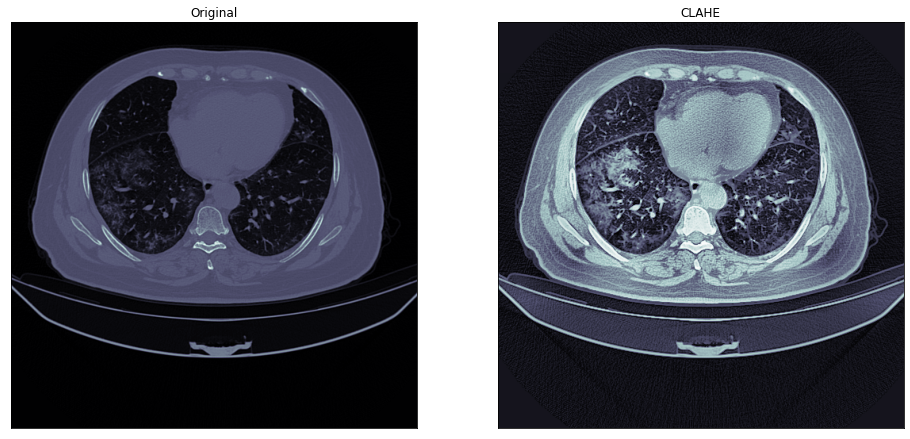

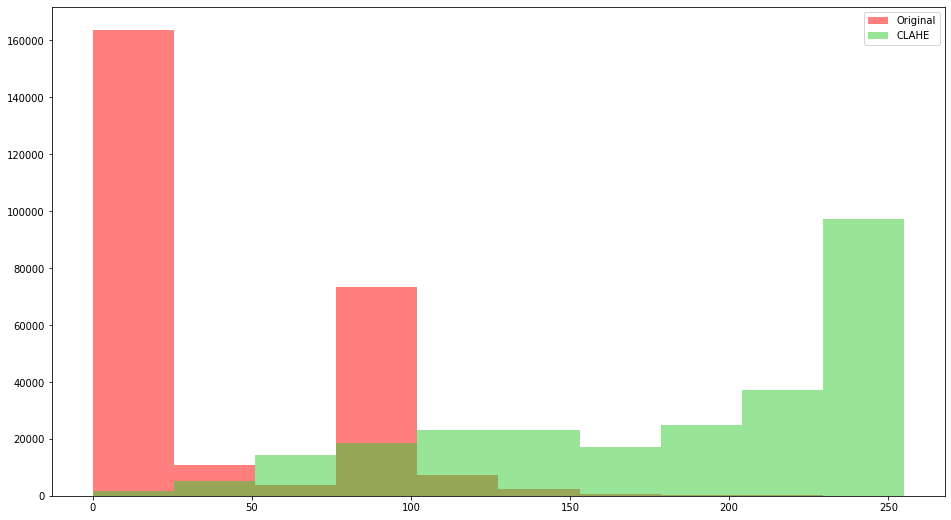

In [5]:
imgs_ct = load_volume(metadata, 'ct_scan', range(100, 200, 20))

N = 1

img = Preprocessor.normalize(imgs_ct[N])
clahe_img = Preprocessor.enhance(img)

_, axes = plt.subplots(ncols=2, figsize=(16, 9))

axes[0].imshow(img, cmap='bone')
axes[0].set_title("Original")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(clahe_img, cmap='bone')
axes[1].set_title("CLAHE")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

_, axes = plt.subplots(figsize=(16, 9))

axes.hist(img.flatten() * 255, alpha=0.5, color='red', label='Original')
axes.hist(clahe_img.flatten() * 255, alpha=0.5, color='limegreen', label="CLAHE")
axes.legend()

plt.show()

del imgs_ct, img, clahe_img
del _, axes, N

# 2. Preprocessing the masks

In [6]:
def binarize_mask(mask, display=False):
    thresholded = Preprocessor.binarize(mask)

    if display:
        _, ax = plt.subplots(ncols=2, figsize=[16, 9])
        ax[0].set_title("Original mask")
        ax[0].imshow(mask, cmap='gray')
        ax[0].axis('off')

        ax[1].set_title("Binarized mask")
        ax[1].imshow(thresholded, cmap='gray')
        ax[1].axis('off')

        plt.show()

    return thresholded

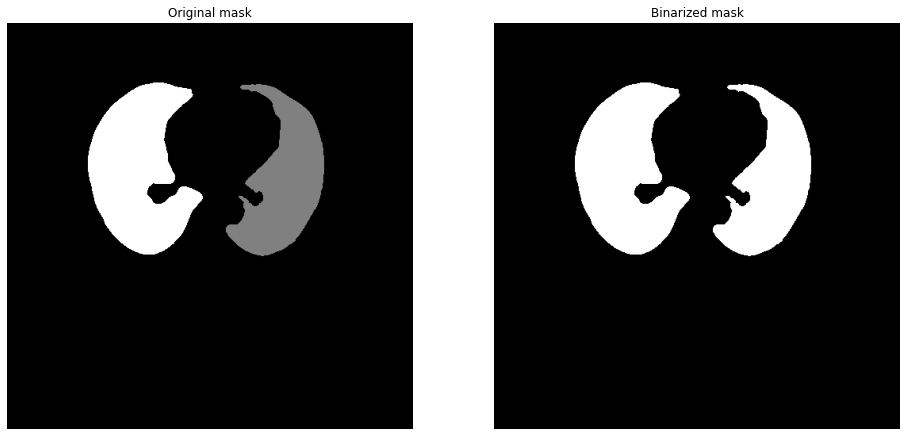

100%|██████████| 10/10 [00:00<00:00, 1667.65it/s]

Before:
	imgs_lungs.min()=0.0
	imgs_lungs.max()=2.0
After:
	imgs_lungs.min()=0.0
	imgs_lungs.max()=1.0


In [7]:
imgs_lungs = load_volume(metadata, 'lung_mask', range(100, 200, 10))

mask_lungs = binarize_mask(imgs_lungs[5], display=True)

print('Before:')
print(f'\t{imgs_lungs.min()=}')
print(f'\t{imgs_lungs.max()=}')

tmp = []

for i in tqdm.trange(len(imgs_lungs)):
    tmp.append(binarize_mask(imgs_lungs[i]))

imgs_lungs = np.array(tmp).copy()

print('After:')
print(f'\t{imgs_lungs.min()=}')
print(f'\t{imgs_lungs.max()=}')

del imgs_lungs, mask_lungs, i, tmp

# 3. Let's apply the above techniques on infection and lung mask

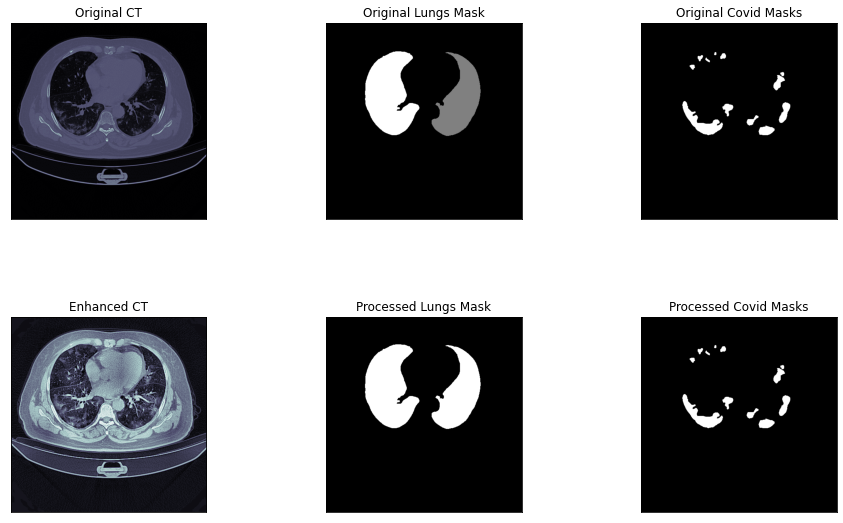

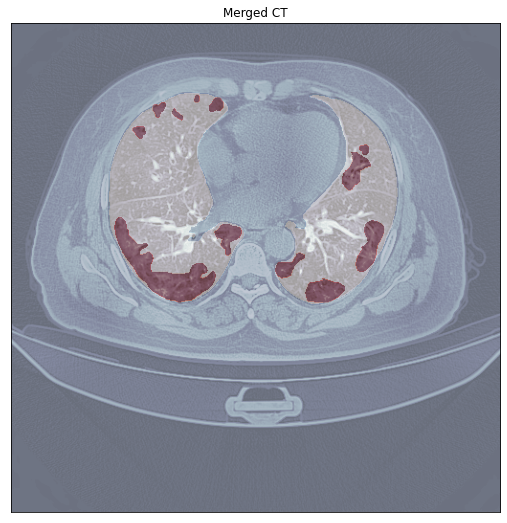

In [8]:
imgs_ct = load_volume(metadata, 'ct_scan', range(100, 200, 10))
imgs_lungs = load_volume(metadata, 'lung_mask', range(100, 200, 10))
imgs_covid = load_volume(metadata, 'infection_mask', range(100, 200, 10))

N = 4
_, axes = plt.subplots(2, 3, figsize=(16, 9))
_ = plt.subplots_adjust(hspace=0.5)


def plot(title, axes, row, column, image, is_mask=True):
    if is_mask:
        axes[row, column].imshow(image, cmap='gray')
    else:
        axes[row, column].imshow(image, cmap='bone')

    axes[row, column].set_title(title)
    axes[row, column].set_xticks([])
    axes[row, column].set_yticks([])


plot('Original CT', axes, row=0, column=0, image=imgs_ct[N], is_mask=False)
plot('Original Lungs Mask', axes, row=0, column=1, image=imgs_lungs[N])
plot('Original Covid Masks', axes, row=0, column=2, image=imgs_covid[N])

img_ct = Preprocessor.enhance(Preprocessor.normalize(imgs_ct[N]))
img_lungs = Preprocessor.binarize(imgs_lungs[N])
img_covid = Preprocessor.binarize(imgs_covid[N])

plot('Enhanced CT', axes, row=1, column=0, image=img_ct, is_mask=False)
plot('Processed Lungs Mask', axes, row=1, column=1, image=img_lungs)
plot('Processed Covid Masks', axes, row=1, column=2, image=img_covid)

plt.show()

plt.figure(figsize=(9, 9))
plt.title('Merged CT')
plt.imshow(img_ct, cmap='bone')
plt.imshow(img_lungs, alpha=0.4, cmap='Blues_r')
plt.imshow(img_covid, alpha=0.4, cmap='Reds')
plt.xticks([])
plt.yticks([])

plt.show()

del imgs_ct, img_ct, imgs_lungs, img_lungs, imgs_covid, img_covid
del N, axes

# 4. Loading all the data

Let's now load all the data and convert it into tensors.

Also in the beginning we should define a range that cuts off $20\%$ of data from the head and $20\%$ from the tail of CT volume.
This will help us to exclude irrelevant data.

In [9]:
def load_volume_cut(meta, name, index=0):
    subset = nib.load(os.path.join(Const.DATASET_PATH, meta[name][index]))
    imgs = subset.get_fdata()
    rng = range(round(imgs.shape[2] * 0.2), round(imgs.shape[2] * 0.8))
    imgs = np.rot90(np.array(imgs))
    imgs = imgs[:, :, rng]
    imgs = np.reshape(
            np.rollaxis(imgs, 2),
            (
                imgs.shape[2],
                imgs.shape[0],
                imgs.shape[1],
                1
            )
    )

    return imgs

In [10]:
processed_imgs_ct = []
processed_imgs_lungs = []
processed_imgs_covid = []

for i in tqdm.trange(metadata.index.stop):
    imgs_ct = load_volume_cut(metadata, 'ct_scan', i)
    imgs_lungs = load_volume_cut(metadata, 'lung_mask', i)
    imgs_covid = load_volume_cut(metadata, 'infection_mask', i)

    for j in range(imgs_ct.shape[0]):
        img_ct = Preprocessor.resize(imgs_ct[j])
        img_lungs = Preprocessor.resize(imgs_lungs[j])
        img_covid = Preprocessor.resize(imgs_covid[j])
        img_ct = Preprocessor.normalize(img_ct)
        processed_imgs_ct.append(Preprocessor.enhance(img_ct))
        processed_imgs_lungs.append(Preprocessor.binarize(img_lungs))
        processed_imgs_covid.append(Preprocessor.binarize(img_covid))

del imgs_ct, imgs_lungs, imgs_covid, img_ct, img_lungs, img_covid
del i, j

100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


In [11]:
print(f'{len(processed_imgs_ct)=}')
print(f'{len(processed_imgs_lungs)=}')
print(f'{len(processed_imgs_covid)=}')

len(processed_imgs_ct)=2112
len(processed_imgs_lungs)=2112
len(processed_imgs_covid)=2112


# 5. Deleting blank masks

Deleting the blank infection masks is important so that our model can easily predict the desired infection mask required.

Here we will delete all the black infection masks along with their corresponding CT scans and lungs masks.
To approach this we will use `np.unique()` to identify the unique elements and if its size is $1$ it means the mask is blank and then store the result in an `to_delete` list.

Then sort the `to_delete` list in descending order and using `del` delete the index on CT scans, lungs masks as well as blank infection masks.

In [12]:
total_slides = len(processed_imgs_ct)
to_delete = []
for i in tqdm.trange(len(processed_imgs_covid)):
    if np.unique(processed_imgs_covid[i]).size == 1:
        to_delete.append(i)

print(f'{len(to_delete)=}')

100%|██████████| 2112/2112 [00:02<00:00, 1036.63it/s]

len(to_delete)=498


Let's check found blank masks.

Number of CT slices available after deletion of non-infection masks = 1614


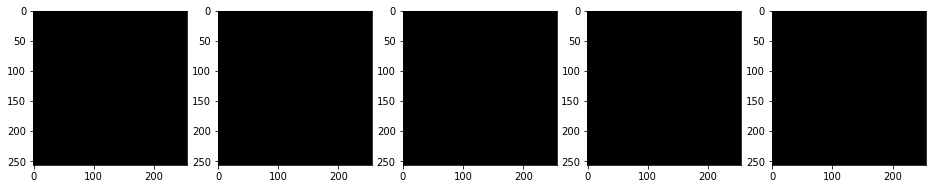

In [13]:
N = 5

_, axes = plt.subplots(ncols=N, figsize=(16, 9))
tmp = 0
for i in to_delete:
    img_covid = processed_imgs_covid[i]
    axes[tmp].imshow(img_covid, cmap='gray')
    tmp += 1
    if tmp == N:
        break

for i in reversed(to_delete):
    del processed_imgs_ct[i]
    del processed_imgs_lungs[i]
    del processed_imgs_covid[i]

print(f'Number of CT slices available after deletion of non-infection masks = {len(processed_imgs_ct)}')

del tmp, total_slides, to_delete, i, img_covid, N, axes

In [14]:
processed_imgs_ct = np.array(processed_imgs_ct)
processed_imgs_lungs = np.array(processed_imgs_lungs)
processed_imgs_covid = np.array(processed_imgs_covid)

print(f'{processed_imgs_ct.shape=}')
print(f'{processed_imgs_lungs.shape=}')
print(f'{processed_imgs_covid.shape=}')

processed_imgs_ct.shape=(1614, 256, 256, 1)
processed_imgs_lungs.shape=(1614, 256, 256, 1)
processed_imgs_covid.shape=(1614, 256, 256, 1)


# 6. Viewing the final images

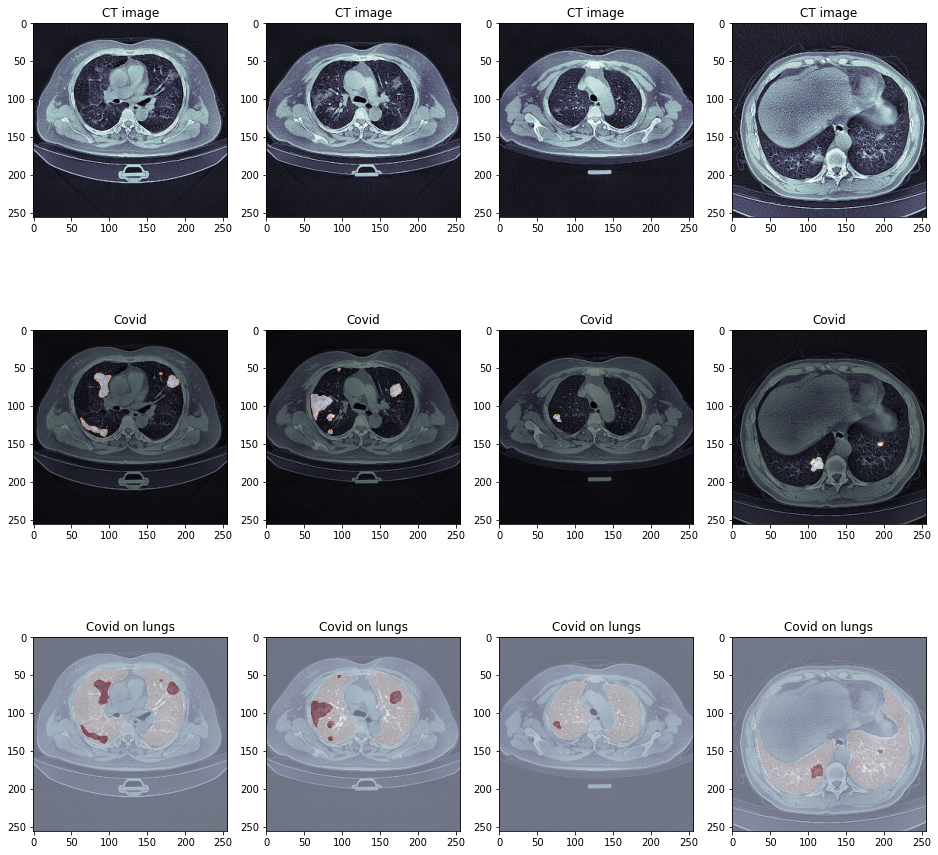

In [15]:
_, axes = plt.subplots(3, 4, figsize=(16, 16))

for column, i in enumerate(range(100, 200, 25)):
    axes[0, column].imshow(processed_imgs_ct[i], cmap='bone')
    axes[0, column].set_title('CT image')

    axes[1, column].imshow(processed_imgs_ct[i], cmap='bone')
    axes[1, column].imshow(processed_imgs_covid[i], alpha=0.5, cmap='afmhot')
    axes[1, column].set_title('Covid')

    axes[2, column].imshow(processed_imgs_ct[i], cmap='bone')
    axes[2, column].imshow(processed_imgs_lungs[i], alpha=0.4, cmap='Blues_r')
    axes[2, column].imshow(processed_imgs_covid[i], alpha=0.4, cmap='Reds')
    axes[2, column].set_title('Covid on lungs')

del axes, column, i

# 7. Saving Data

Save these processed images so that this procedure can be avoided in the future.

In [16]:
if not os.path.exists(Const.CT_IMAGES_PATH):
    os.makedirs(Const.CT_IMAGES_PATH)
if not os.path.exists(Const.LUNGS_IMAGES_PATH):
    os.makedirs(Const.LUNGS_IMAGES_PATH)
if not os.path.exists(Const.COVID_IMAGES_PATH):
    os.makedirs(Const.COVID_IMAGES_PATH)

N = len(processed_imgs_ct)
z_fill = len(str(N))
for i in tqdm.trange(N):
    ct_path = os.path.join(Const.CT_IMAGES_PATH, f'{str(i).zfill(z_fill)}.png')
    lungs_path = os.path.join(Const.LUNGS_IMAGES_PATH, f'{str(i).zfill(z_fill)}.png')
    covid_path = os.path.join(Const.COVID_IMAGES_PATH, f'{str(i).zfill(z_fill)}.png')

    cv.imwrite(ct_path, processed_imgs_ct[i])
    cv.imwrite(lungs_path, processed_imgs_lungs[i] * 255)
    cv.imwrite(covid_path, processed_imgs_covid[i] * 255)

del N, z_fill, ct_path, lungs_path, covid_path, i
del processed_imgs_ct, processed_imgs_lungs, processed_imgs_covid
del metadata

100%|██████████| 1614/1614 [00:13<00:00, 123.97it/s]
